# Flow Matching

In [1]:
import time
import torch

import matplotlib.pyplot as plt

from Engine import *
from pathlib import Path
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

### Conditional Flow Matching

In [8]:
%%time
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = CFM(sigma=sigma)

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end

        node = NeuralODE(torch_wrapper(model), solver="euler")
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj=traj.cpu().numpy())
        
        evaluate(traj[-1].cpu(), sample_moons(1024))

KeyboardInterrupt: 

### Optimal Transport Conditional Flow Matching

Next we implement optimal transport conditional flow matching. As in the paper, here we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= \pi(x_0, x_1) \\
p_t(x | z) &= \mathcal{N}(x | t * x_1 + (1 - t) * x_0, \sigma^2) \\
u_t(x | z) &= x_1 - x_0
\end{align}
$$
where $\pi$ is the joint of an exact optimal transport matrix. We first sample random $x_0, x_1$, then resample according to the optimal transport matrix as computed with the python optimal transport package. We use the 2-Wasserstein distance with an $L^2$ ground distance for equivalence with dynamic optimal transport.

5000: loss 0.098 time 46.68


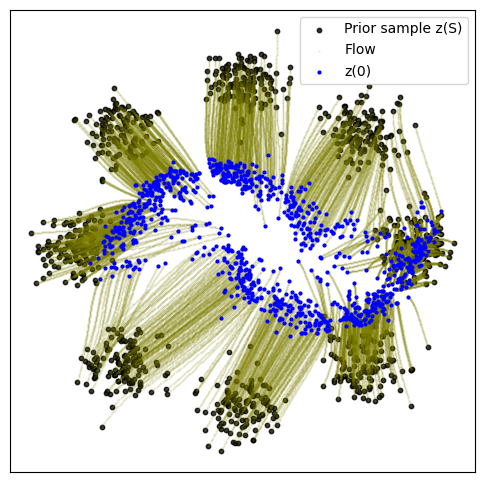

Fréchet Distance: 0.0193. Hausdorff Distance: 1.2183. Energy Distance: 0.0456.

10000: loss 0.135 time 46.85


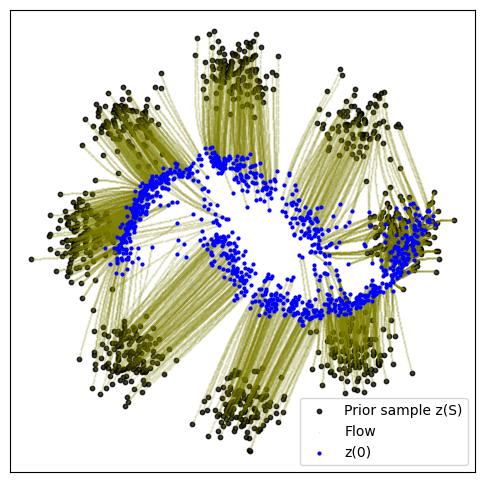

Fréchet Distance: 0.0623. Hausdorff Distance: 1.2132. Energy Distance: 0.0862.

15000: loss 0.152 time 49.23


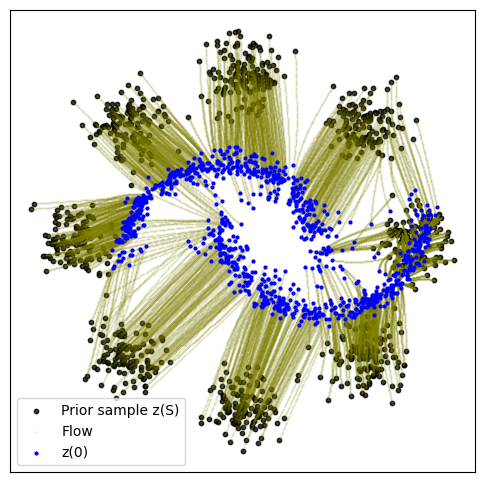

Fréchet Distance: 0.0173. Hausdorff Distance: 1.3073. Energy Distance: 0.0346.

20000: loss 0.172 time 49.45


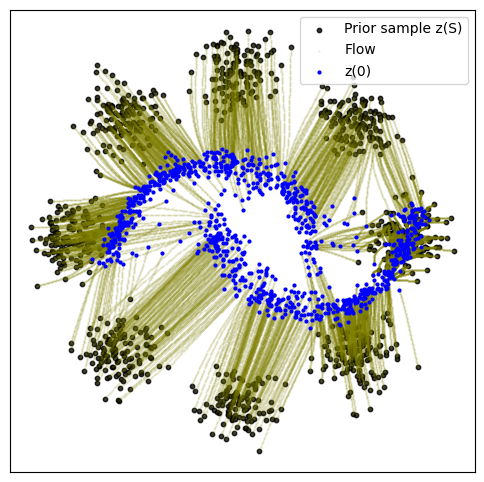

Fréchet Distance: 0.0215. Hausdorff Distance: 1.2128. Energy Distance: 0.0321.

CPU times: user 3min 14s, sys: 29.4 s, total: 3min 43s
Wall time: 3min 13s


In [3]:
%%time
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = OT_CFM(sigma=sigma)

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(torch_wrapper(model), solver="euler")
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj=traj.cpu().numpy())
        
        evaluate(traj[-1].cpu(), sample_moons(1024))

### Lipman's Optimal Transport Conditional Flow Matching

5000: loss 7.922 time 43.90


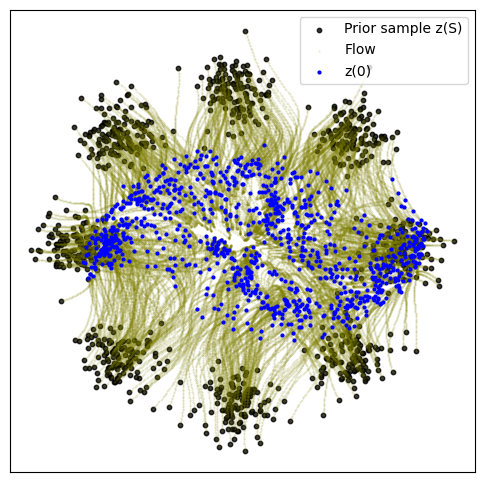

Fréchet Distance: 0.1510. Hausdorff Distance: 1.3881. Energy Distance: 0.0784.

10000: loss 7.149 time 46.77


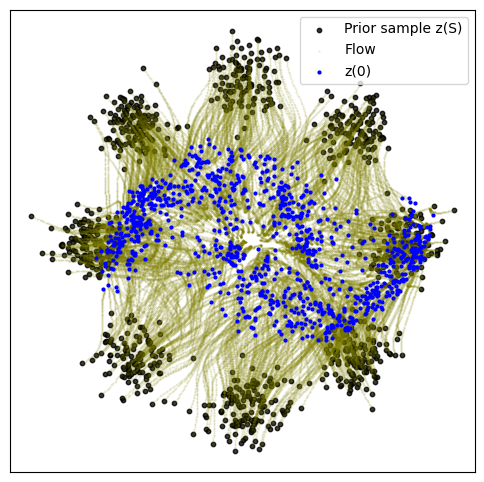

Fréchet Distance: 0.1261. Hausdorff Distance: 1.3779. Energy Distance: 0.0899.

15000: loss 6.938 time 45.68


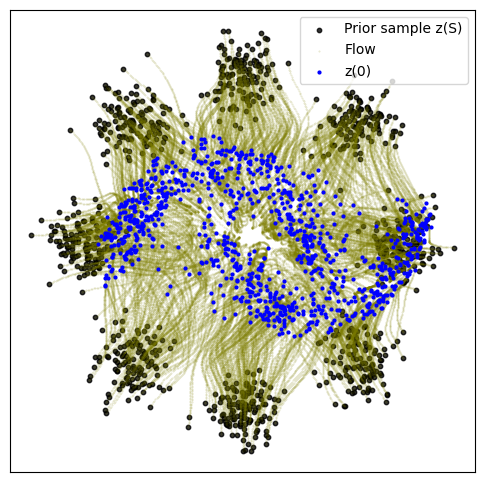

Fréchet Distance: 0.1340. Hausdorff Distance: 1.5064. Energy Distance: 0.0727.

20000: loss 7.065 time 32.45


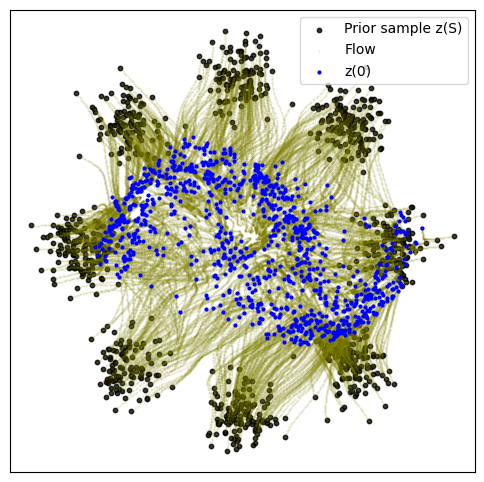

Fréchet Distance: 0.1639. Hausdorff Distance: 1.6544. Energy Distance: 0.1024.

CPU times: user 9min 24s, sys: 54.9 s, total: 10min 19s
Wall time: 2min 49s


In [4]:
%%time
sigma = 0.1
dim = 2
batch_size = 256 * 4
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = LOT_CFM(sigma=sigma)

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    psi_t = FM.psi_t(x1, x0, t)
    vt = model(torch.cat([psi_t, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(torch_wrapper(model), solver="euler")
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj=traj.cpu().numpy())
        
        evaluate(traj[-1].cpu(), sample_moons(1024))

### Variational Flow Matching

5000: loss 469.784 time 9.80


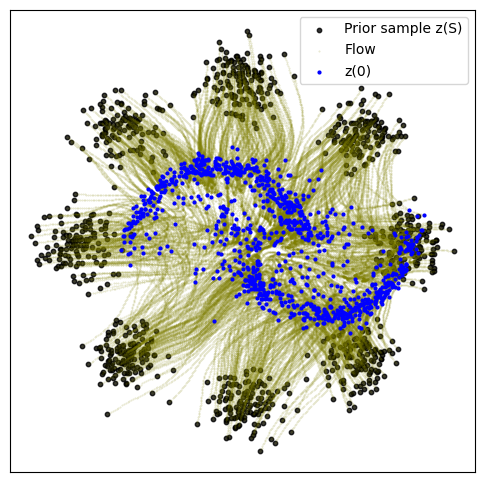

Fréchet Distance: 0.2832. Hausdorff Distance: 1.2328. Energy Distance: 0.1316.

10000: loss 416.007 time 10.39


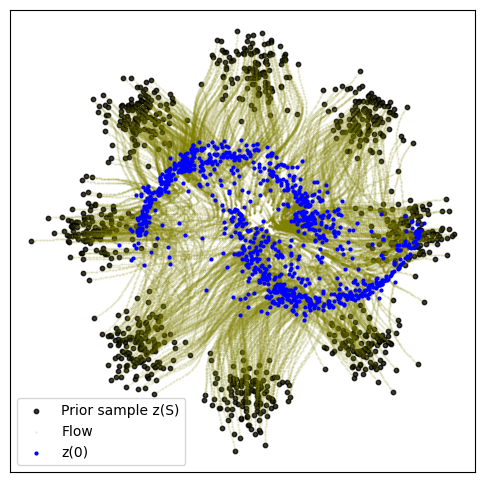

Fréchet Distance: 0.2070. Hausdorff Distance: 1.1812. Energy Distance: 0.1029.

15000: loss 394.784 time 10.41


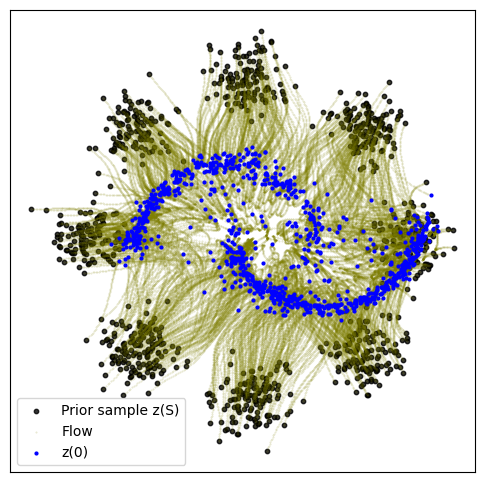

Fréchet Distance: 0.0276. Hausdorff Distance: 1.4622. Energy Distance: 0.0857.

20000: loss 414.249 time 10.58


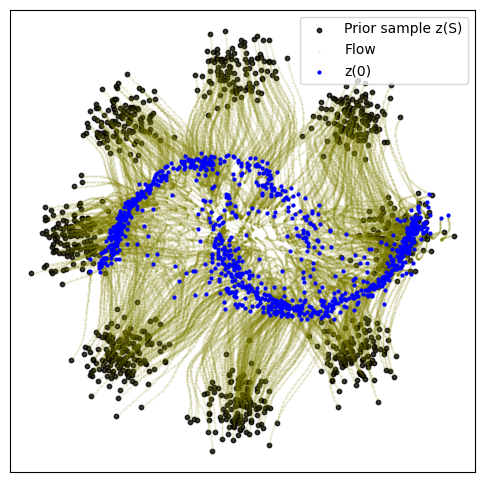

Fréchet Distance: 0.2354. Hausdorff Distance: 1.5841. Energy Distance: 0.1473.

CPU times: user 45.3 s, sys: 14.4 s, total: 59.7 s
Wall time: 42 s


In [15]:
%%time
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = CFM(sigma=sigma)
criterion = torch.nn.GaussianNLLLoss()

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))

    var = torch.full_like(vt, sigma**2)
    var.requires_grad = False

    loss = criterion(vt, ut, var)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(torch_wrapper(model), solver="euler")
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj=traj.cpu().numpy())
        
        evaluate(traj[-1].cpu(), sample_moons(1024))

### Stochastic Gradients

### VFM with learned sigma

In [ ]:

sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = CFM(sigma=sigma)
criterion = torch.nn.GaussianNLLLoss()

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))

    var = torch.full_like(vt, sigma**2)
    var.requires_grad = False

    loss = criterion(vt, ut, var)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(torch_wrapper(model), solver="euler")
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj=traj.cpu().numpy())
        
        evaluate(traj[-1].cpu(), sample_moons(1024))